# Bearing Anomaly Detection using Machine Learning

## 1. Introduction

Condition monitoring of an equipment is one of the crucial aspect one must conduct while operating an equipment or a machinery. The program can help identify the health state of the equipment so the operator can take necessary actions to mitigate an equipment failure.

The most common way to perform condition monitoring is to look at each sensor measurement from the machine and to set a minimum and maximum value limit on the measurement. If the measurement value is within the bounds, then the equipment is likely healthy. If the measurement value is outside the minimum or maximum bounds, then the equipment is unhealthy and a warning is sent.

Due to sheer amount of signals that are measured and transmitted from many sensors, the system is prone to either sending a large number of false alarms, i.e. sending unnecessary alarms or missing alarms, i.e. not sending required alarms. In order to mitigate this situation, it is necessary to have a reliable computational method which can analyze and make correct judgements from the combined data collected from various measurements by the available sensors.

In this notebook, we will be discussing two different approaches of unsupervised machine learning methods for anomaly detection to help operators monitor the conditions of a working machinery. The two different types of unsupervised machine learning methods are:

* Principal Component Analysis (PCA) combined with Mahalanobis distance
* Autoencoder

To understand how the aforementioned unsupervised machine learning algorithms work, we will be discussing and taking a closer look at how they work in code throughout this notebook.

## 2. Data

The bearing dataset was provided provided by the Center for Intelligent Maintenance Systems (IMS), University of Cincinnati and is available at [Kaggle](https://www.kaggle.com/vinayak123tyagi/bearing-dataset). There exists 3 datasets in total and each dataset consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. For this project, the second dataset was selected.

In the second dataset, there exists 984 data files with a measurement interval of 10 minutes between each two adjacent data file, and each data file has 20,480 measurements. This means a measurement exercise of the equipment was conducted every 10 minutes and in each exercise 20,480 measurements were taken.

For each measurement, there are 4 different parameters recorded, representing 4 different types of bearings of the equipment. This project is essentially studying the interactions between the 4 bearings. In this project, we will be taking an average of all 20,480 measurements with a final dataset of 984 rows and 4 columns.

The purpose of taking the average is for simplicity and the reduction of noise among individual measurements. However, one can actually train a more sophisticated model by using the large number of individual measurements without taking the average.

In [1]:
import os 
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = "data/2nd_test"
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    # each file consists of 20480 rows of data with the sampling rate set at 20 kHz
    # data in each two adjacent files are measured 10 minutes away from each other
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    
    # for the purpose of the anomaly detection study, we only keep the mean of the 20480 data points in each file
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
# rename columns    
merged_data.columns = ["Bearing 1", "Bearing 2", "Bearing 3", "Bearing 4"]
# format index into date time format
merged_data.index = pd.to_datetime(
    merged_data.index, format="%Y.%m.%d.%H.%M.%S" 
)
# sort by index
merged_data = merged_data.sort_index()

print("Data shape: ", merged_data.shape)

Data shape:  (984, 4)


In [3]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


Plotting the raw data with respect to its index (time of observation) we get the following plot:

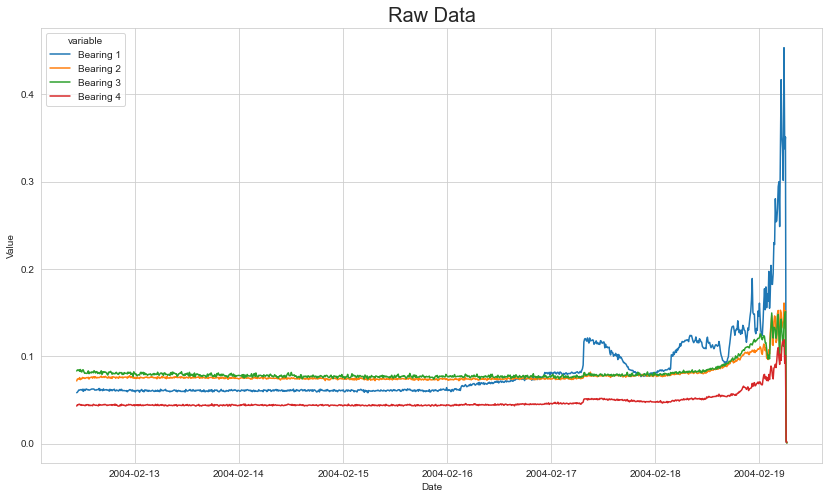

In [4]:
data_melt_merged_data = pd.melt(merged_data.reset_index(), id_vars="index")

plt.figure(figsize=(14,8))
sns_plot = sns.lineplot(x="index", y="value", hue="variable", 
                        data=data_melt_merged_data)

sns_plot.set_title("Raw Data", fontsize=20)
sns_plot.set_xlabel("Date")
sns_plot.set_ylabel("Value")

plt.show()

From the plot above we notice that **Bearing 1 started to deviate from original trend after 2004-02-16** while others still performed quite normal until after 2004-02-18. In traditional Statistical Process Control (SPC), if we are unlucky, we may not have selected Bearing 1 to be monitored and may not have detected any issue before 2004-02-19, when a breakdown event occurred.

## 3. Define train/test data

Before setting up the models, we need to define the train and test data. To do this, we perform a simple train test split where we train on the first part of the dataset (which should represent normal operating conditions), and test on the remaining parts of the dataset leading up to the bearing failure.

In [5]:
train_data = merged_data["2004-02-12 11:02:39":"2004-02-13 23:52:39"]
test_data = merged_data["2004-02-13 23:52:39":]

print("Train Data: ", train_data.shape)
print("Test Data: ", test_data.shape)

Train Data:  (222, 4)
Test Data:  (760, 4)


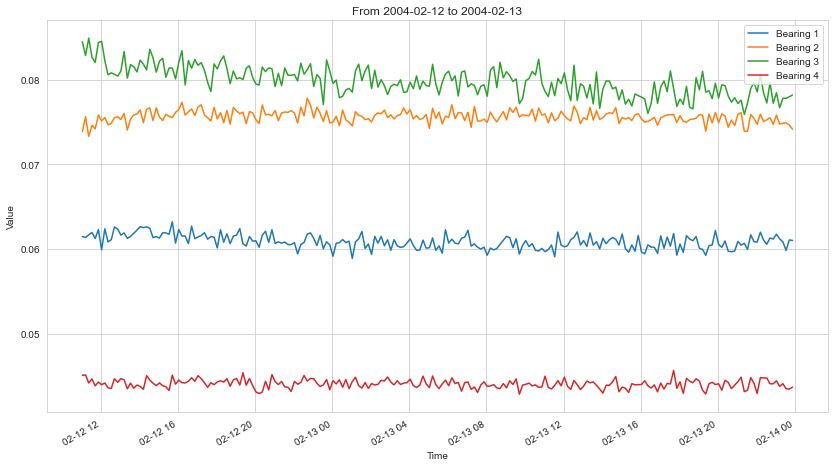

In [6]:
train_data.plot(figsize=(14,8))

plt.title("From 2004-02-12 to 2004-02-13")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

Next, preprocessing tools of Scikit-learn will be used to scale the input variables of the model. Here, the MinMaxScaler will rescale the data to be in the range of [0,1].

In [7]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train_data), 
                       columns=train_data.columns, 
                       index=train_data.index)

X_test = pd.DataFrame(scaler.transform(test_data), 
                      columns=test_data.columns, 
                      index=test_data.index)

In [8]:
X_test.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-13 23:52:39,0.489779,0.187746,0.255713,0.298511
2004-02-14 00:02:39,0.354621,0.227843,0.244457,0.425398
2004-02-14 00:12:39,0.249681,0.309895,0.231099,0.254432
2004-02-14 00:22:39,0.303792,0.376130,0.195196,0.608553
2004-02-14 00:32:39,0.610786,0.502812,0.162301,0.380454


## 4. Approach 1: Multivariate Statistical Analysis (MSA)

The first approach we are going to show is to apply Principal Component Analysis (PCA) in combination with the Mahalanobis distance. Before jumping into the analysis, let's define some required functions below:

In [9]:
# covariance matrix calculation
def cov_matrix(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_convariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_convariance_matrix):
            return covariance_matrix, inv_convariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
        
# Mahalanobis distance calculation
def Mahalanobis_dist(inv_convariance_matrix, mean_dist, data):
    diff = data - mean_dist
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_convariance_matrix).dot(diff[i])))
    return md

# outlier detection
def MD_detect_outliers(dist, extreme=False):
    k = 3.0 if extreme else 2.0
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i) # append index of outlier
    return np.array(outliers)

# threshold value calculation for classifying datapoint as anomaly
def MD_threshold(dist, std_dev=4):
    threshold = np.mean(dist) + np.std(dist) * std_dev
    return threshold

# Check if matrix is positive definite
def is_pos_def(matrix):
    if np.allclose(matrix, matrix.T):
        try:
            np.linalg.cholesky(matrix)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

Having split the dataset into train and test data, we will now build a model that can detect anomalies from the bearing datasets. This section will be split into two subsections; first is building the model using PCA, second is anomaly detection using Mahalanobis distance.

## 4.1 Principal Component Analysis (PCA) application to the MSA

Dealing with high-dimensional data is often computationally challenging. Luckily there are several techniques to reduce the number of variables. One of the most popular dimension reduction techniques we are going to use is Principal Component Analysis (PCA).

Here, PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. In practice, the covariance matrix of the data is constructed and the eigenvectors of this matrix are computed. The eigenvectors that correspond to the largest eigenvalues (the principal components) can now be used to reconstruct a large fraction of the variance of the original data. The original feature space has now been reduced to the space spanned by a few eigenvectors.

In [10]:
from sklearn.decomposition import PCA

# only keep the first two principal components
pca = PCA(n_components=2, svd_solver="full")

X_train_PCA = pca.fit_transform(X_train)
# prints the variance explained by the first two principal components
print(pca.explained_variance_)

[0.06830952 0.02739669]


In [11]:
# X_train_PCA shape -> (number of train data, number of principal components)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
# X_test_PCA shape -> (number of test data, number of principal components)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

# principal_components_train shape -> (number of train data, number of principal components)
principal_components_train = np.array(X_train_PCA.values)
# principal_components_test shape -> (number of test data, number of principal components)
principal_components_test = np.array(X_test_PCA.values)

In [12]:
print(f"Explained variance per principal component: {pca.explained_variance_ratio_}")

Explained variance per principal component: [0.51012041 0.20459247]


From the above output, we can observe that the principal component 1 holds 51.0% of the information while the principal component 2 holds only 20.4% of the information. Also, the other point to note is that while projecting four-dimensional data to a two-dimensional data, 28.6% of information was lost.

## 4.2 Anomaly detection using Mahalanobis distance

How to check that an observed point is anomalous? Let's consider the problem of estimating that a data point belong to a set of points. The first step would be to find the centroid or center of the set as representative of the set. Intuitively, the closer the sample point to the center of mass, the more likely it belongs to the set.

However, we also need to know if the set is spread out over a large range or a small range, so that we can decide whether a given distance from the center is noteworthy or not. The simplistic approach is to estimate the standard deviation of the distances of the sample points from the center of mass. By plugging this into the normal distribution we derive the probability of the data point belonging to the same distribution.

The drawback of the above approach was that we assumed the sample points are distributed around the centroid in a spherical manner. When we face a non-spherical distribution, e.g. an ellipsoidal, we would expect the probability of the test point belonging to the set to depend not only on the distance from the centroid, but also on the direction. In those directions where the ellipsoid has a short axis the test point must be closer, while in those where the axis is long the test point can be further away from the center.

Putting this on a mathematical basis, the ellipsoid that best represents the set’s probability distribution can be estimated by calculating the covariance matrix of the samples. The Mahalanobis distance (MD) is the distance of the test point from the centroid divided by the width of the ellipsoid in the direction of the test point.

In [13]:
# calculate the covariance matrix and its inverse, based on principal components of train data
# covariance_matrix shape -> (number of principal components, number of principal components)
# inv_covariance_matrix shape -> (number of principal components, number of principal components)
covariance_matrix, inv_covariance_matrix = cov_matrix(principal_components_train)

# calculate the mean value for the principal components of train set, as this is used later
# to calculate the Mahalanobis distance to datapoints in the test set
# mean_dist shape -> (number of principal components, )
mean_dist = principal_components_train.mean(axis=0)

# calculate the Mahalanobis distance for train set
# dist_train length = number of train data
dist_train = Mahalanobis_dist(
    inv_covariance_matrix,
    mean_dist,
    principal_components_train
)

# find the threshold value to flag data points as anomalous based on train set
# threshold: a number, type numpy.float64
threshold =  MD_threshold(dist_train, std_dev=4)

# calculate the Mahalanobis distance for test set, to be compared with the anomaly threshold
# dist_test length = number of test data
dist_test = Mahalanobis_dist(
    inv_covariance_matrix,
    mean_dist,
    principal_components_test
)

The square of the Mahalanobis distance to the centroid of the distribution should follow chi-square (χ2) distribution if the assumption of normal distributed input variables is fulfilled. This is also the assumption behind the above calculation of the “threshold value” for flagging an anomaly. As this assumption is not necessarily fulfilled in our case, it is beneficial to visualize the distribution of the Mahalanobis distance to set a good threshold value for flagging anomalies.

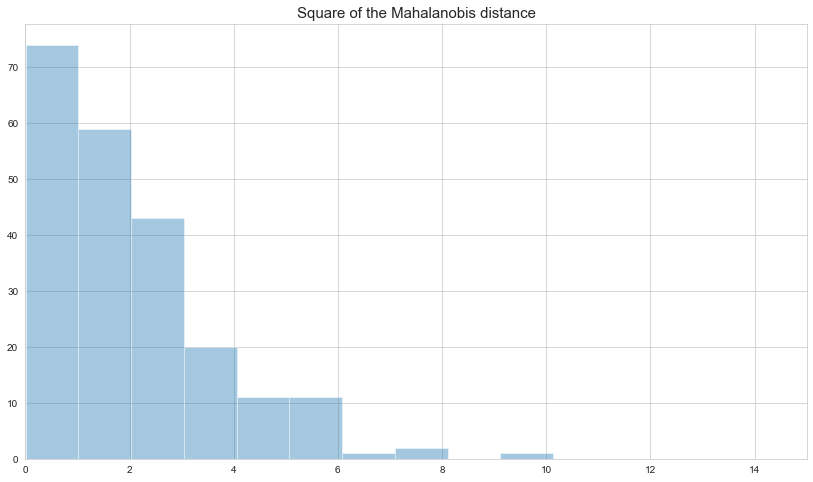

In [14]:
plt.figure(figsize=(14,8))
sns.distplot(np.square(dist_train), 
             bins=10, 
             kde=False)

plt.title("Square of the Mahalanobis distance", fontsize=15)
plt.xlim([0.0, 15.0])
plt.show()

Visualizing the Mahalanobis distance we get the following plot:

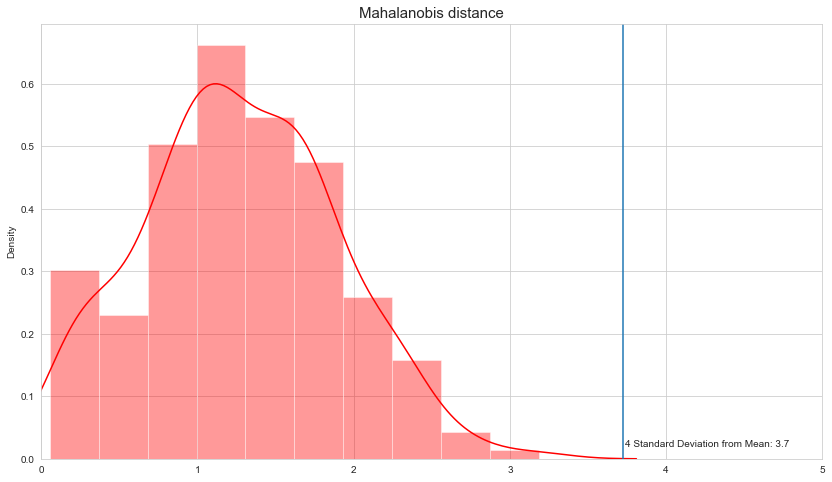

In [15]:
plt.figure(figsize=(14,8))
sns.distplot(dist_train, 
             bins=10, 
             kde=True, 
             color="red")

plt.title("Mahalanobis distance", fontsize=15)
plt.axvline(threshold)
plt.text(threshold + 0.01, 0.02, "4 Standard Deviation from Mean: " + str(round(threshold, 1)))
plt.xlim([0.0, 5.0])
plt.show()

From the distribution above we can set the anomaly threshold equal to 4 standard deviations from the mean of the Mahalanobis distancess in the train data.

Mahalanobis distance of the train data, threshold value and anomaly flag variable for both train and test data can be saved to a dataframe.

In [16]:
#save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable 
# for both train and test data to a dataframe
anomaly_train = pd.DataFrame() 
anomaly_train["Mob dist"] = dist_train
anomaly_train["Threshold"] = threshold

# if Mob dist above threshold, flag as anomaly
anomaly_train["Anomaly"] = anomaly_train["Mob dist"] > anomaly_train["Threshold"]
anomaly_train.index = X_train_PCA.index

anomaly_test = pd.DataFrame()
anomaly_test["Mob dist"] = dist_test
anomaly_test["Threshold"] = threshold
anomaly_test["Anomaly"] = anomaly_test["Mob dist"] > anomaly_test["Threshold"]
anomaly_test.index = X_test_PCA.index

anomaly_test.head()

,Mob dist,Threshold,Anomaly
2004-02-13 23:52:39,1.032676,3.724605,False
2004-02-14 00:02:39,1.148163,3.724605,False
2004-02-14 00:12:39,1.509998,3.724605,False
2004-02-14 00:22:39,1.849725,3.724605,False
2004-02-14 00:32:39,0.701075,3.724605,False


In [17]:
anomaly_alldata = pd.concat([anomaly_train, anomaly_test], axis=0)
anomaly_alldata.to_csv('anomaly_distance.csv')

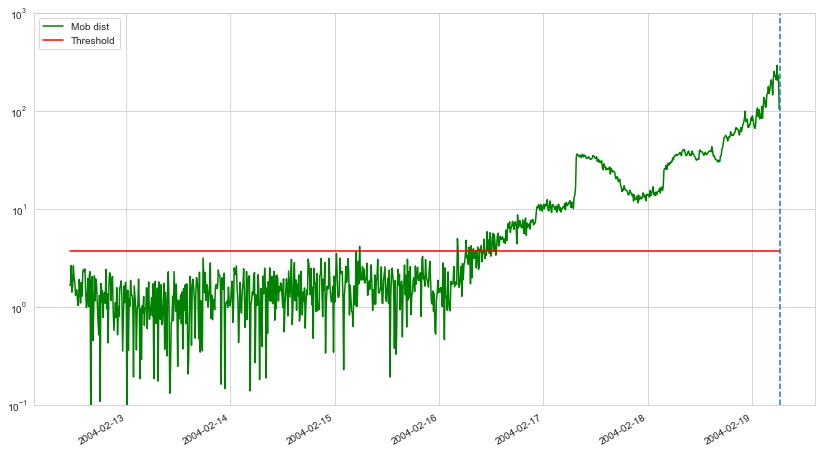

In [18]:
anomaly_alldata.plot(logy=True, 
                     figsize=(14,8), 
                     ylim=[1e-1, 1e3], 
                     color=["green", "red"])

plt.axvline(anomaly_alldata.index[-1], linestyle='--')
plt.show()

The chart above shows that the failure can be detected between **2004-02-16 to 2004-02-17** without the risk of missing Bearing 1. That's 2 days before when the breakdown actually occurred, on 2004-02-19.

## 5. Approach 2: Autoencoder model for anomaly detection (PyTorch) 

An autoencoder is a type of artificial neural network used to learn efficient data encodings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input.

In this case study, the distribution of the reconstruction loss of the autoencoder for training data is plotted to identify where normally reconstruction loss lies and come up with a threshold as the upper control limit. One can also compute the 3 standard deviations from the mean of reconstruction loss to determine an appropriate upper control limit, similar to what have been done in the first modeling approach above.

Before building the model, let's import necessary libraries for the analysis.

**Note: For code in TensorFlow refer below.**

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time
import copy
from numpy.random import seed

seed(10)
torch.manual_seed(10)

## 5.1 Define model and train model

Now let's define an autoencoder and train the model accordingly.

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ELU(),
            nn.Linear(10, 2),
            nn.ELU() 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ELU(),
            nn.Linear(10, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

The ELU (Exponential Linear Unit) activation function is used, which returns x if x > 0 and exp((x)-1) if x < 0). Such choice allows faster convergence of model weigths compared to RELU because of non-null output for x < 0. No difference was observed based on variation of the initialization of weights. This may mean that model training is complete after 100 iterations, and thus results are stable.



In [21]:
# initialize hyperparameters
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 10
SHOW_PROGRESS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train validation split
input_train, input_val, _, _ = train_test_split(X_train, X_train, test_size=0.2, random_state=10)

# convert numpy to torch tensor
input_train = torch.from_numpy(input_train.values).float().to(device)
input_val = torch.from_numpy(input_val.values).float().to(device)

# create torch dataset
train_dataset = torch.utils.data.TensorDataset(input_train)
val_dataset = torch.utils.data.TensorDataset(input_val)

# create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, drop_last=True)

# training...
epochs = []
losses_train = []
losses_val = []
lowest_loss = 1e10 # initialize some huge loss

best_epoch = 0

checkpoint = time.time()
for epoch in range(NUM_EPOCHS):
    epochs.append(epoch+1)
    
    epoch_losses_train = []
    for data_train in train_dataloader:
        
        model.train()
        optimizer.zero_grad()
        
        prediction = model(data_train[0])
        loss = criterion(prediction, data_train[0])
        
        loss.backward()
        optimizer.step()
        
        epoch_losses_train.append(loss.item())
        
        
    epoch_losses_train = np.average(np.array(epoch_losses_train))
    losses_train.append(epoch_losses_train)
    
    epoch_losses_val = []
    for data_val in val_dataloader:
        
        model.eval()
        with torch.no_grad():
            prediction = model(data_val[0])
            loss = criterion(prediction, data_val[0])
            epoch_losses_val.append(loss.item())
            
    epoch_losses_val = np.average(np.array(epoch_losses_val))
    losses_val.append(epoch_losses_val)
    
    # show training progress at pre-defined interval
    if (epoch+1) % SHOW_PROGRESS == 0:
        print(f"Epoch: {epoch+1} | Train loss: {epoch_losses_train:.4f} | Validation loss: {epoch_losses_val:.4f}")
            
            
    # save best model
    if epoch_losses_val < lowest_loss:
        lowest_loss = epoch_losses_val
        best_epoch = epoch + 1
        best_model = copy.deepcopy(model.state_dict())
        
time_elapsed = time.time() - checkpoint
print("Training completed in {:.0f}m {:.0f}s".format(
    time_elapsed // 60,
    time_elapsed % 60
))

print(f"Lowest validation loss: {lowest_loss:.4f} at epoch {best_epoch}")

model.load_state_dict(best_model)

Epoch: 5 | Train loss: 0.0841 | Validation loss: 0.0843
Epoch: 10 | Train loss: 0.0295 | Validation loss: 0.0332
Epoch: 15 | Train loss: 0.0281 | Validation loss: 0.0306
Epoch: 20 | Train loss: 0.0261 | Validation loss: 0.0285
Epoch: 25 | Train loss: 0.0226 | Validation loss: 0.0249
Epoch: 30 | Train loss: 0.0195 | Validation loss: 0.0221
Epoch: 35 | Train loss: 0.0170 | Validation loss: 0.0194
Epoch: 40 | Train loss: 0.0147 | Validation loss: 0.0178
Epoch: 45 | Train loss: 0.0146 | Validation loss: 0.0164
Epoch: 50 | Train loss: 0.0138 | Validation loss: 0.0160
Epoch: 55 | Train loss: 0.0135 | Validation loss: 0.0166
Epoch: 60 | Train loss: 0.0129 | Validation loss: 0.0171
Epoch: 65 | Train loss: 0.0118 | Validation loss: 0.0155
Epoch: 70 | Train loss: 0.0116 | Validation loss: 0.0160
Epoch: 75 | Train loss: 0.0113 | Validation loss: 0.0156
Epoch: 80 | Train loss: 0.0107 | Validation loss: 0.0150
Epoch: 85 | Train loss: 0.0109 | Validation loss: 0.0147
Epoch: 90 | Train loss: 0.0105 |

<All keys matched successfully>

The training results are gathered in a dataframe and plotted against the epochs.

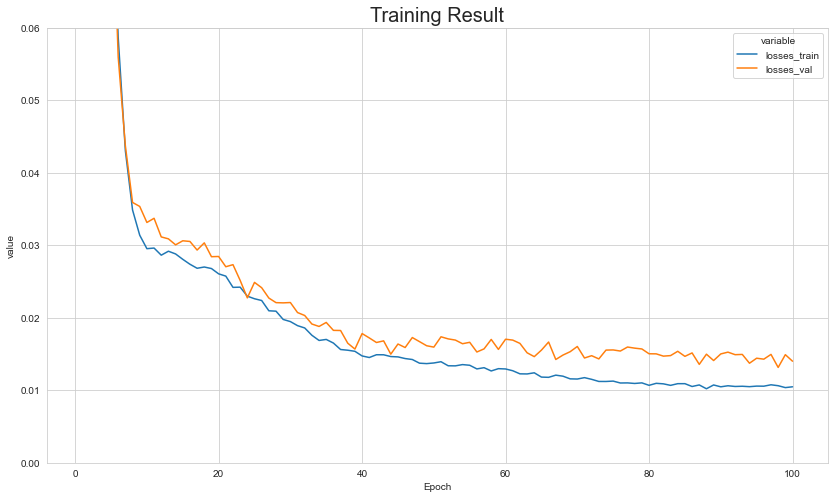

In [22]:
train_result_df = pd.DataFrame(list(zip(epochs, losses_train, losses_val)), columns=["Epoch", 
                                                                                     "losses_train", 
                                                                                     "losses_val"])

train_result_melt_df = pd.melt(train_result_df, id_vars="Epoch", value_vars=["losses_train", "losses_val"])

# lineplot
plt.figure(figsize=(14,8))
sns.lineplot(x="Epoch", y="value", hue="variable",
            data=train_result_melt_df)

plt.title("Training Result", fontsize=20)
plt.ylim(0.0, 0.06)
plt.show()

## 5.2 Distribution of loss function in the training set

By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing so, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

From our result, we can use a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

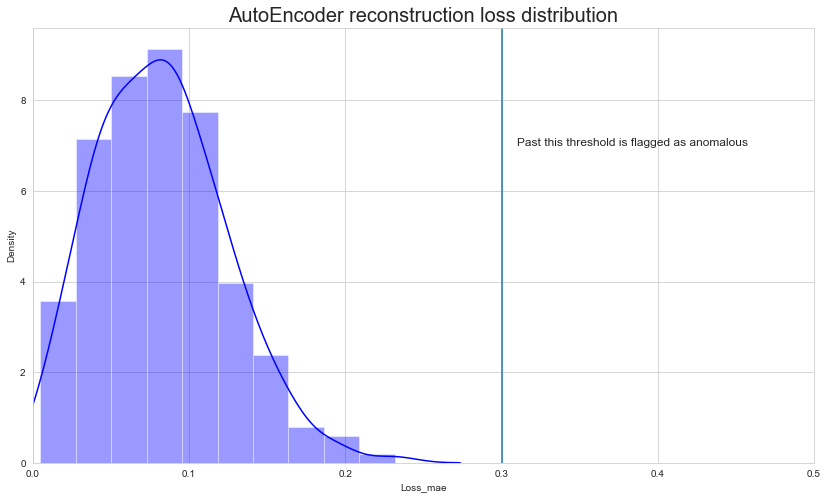

In [23]:
model.eval()
with torch.no_grad():
    X_pred_train = model(torch.from_numpy(X_train.values).float().to(device)).detach().cpu().numpy()
    
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train["Loss_mae"] = np.mean(np.abs(X_pred_train - X_train), axis=1) # predicted value - actual value
plt.figure(figsize=(14,8))
sns.distplot(scored_train["Loss_mae"], 
             bins=10, 
             kde=True,
            color="blue")

plt.axvline(0.3)
plt.text(0.3+0.01, 7, "Past this threshold is flagged as anomalous", fontsize=12)

plt.title("AutoEncoder reconstruction loss distribution", fontsize=20)
plt.xlim([0.0, 0.5])
plt.show()

From the above loss distribution, let us try a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

In [24]:
THRESHOLD = 0.3

model.eval()
with torch.no_grad():
    X_pred_test = model(torch.from_numpy(X_test.values).float().to(device)).detach().cpu().numpy()
    
X_pred_test = pd.DataFrame(X_pred_test, columns=X_test.columns)
X_pred_test.index = X_test.index

scored_test = pd.DataFrame(index=X_test.index)
scored_test["Loss_mae"] = np.mean(np.abs(X_pred_test - X_test), axis=1)
scored_test["Threshold"] = THRESHOLD
scored_test["Anomaly"] = scored_test["Loss_mae"] > scored_test["Threshold"]
display(scored_test.head())

scored_train["Threshold"] = THRESHOLD
scored_train["Anomaly"] = scored_train["Loss_mae"] > scored_train["Threshold"]

scored = pd.concat([scored_train, scored_test], axis=0)

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.114040,0.3,False
2004-02-14 00:02:39,0.090296,0.3,False
2004-02-14 00:12:39,0.015087,0.3,False
2004-02-14 00:22:39,0.118207,0.3,False
2004-02-14 00:32:39,0.105142,0.3,False


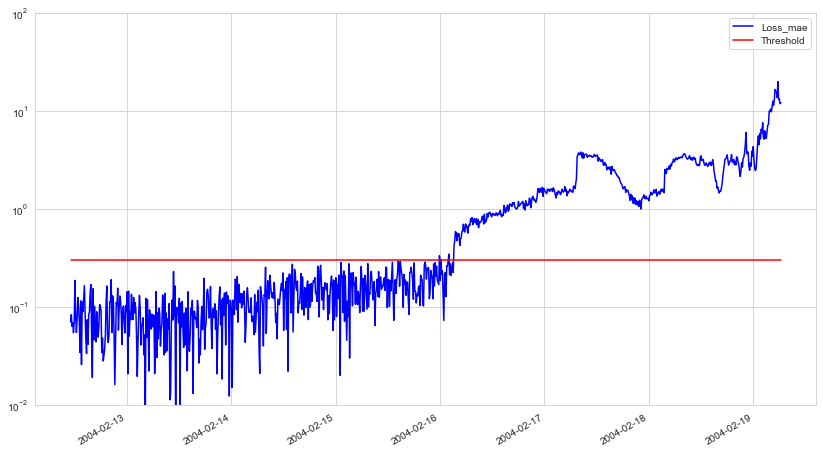

In [25]:
# plot AutoEncoder reconstruction loss over time
scored.plot(logy=True, figsize=(14,8), ylim=[1e-2, 1e2], color=["blue", "red"])
plt.show()

Similar to the PCA with Mahalanobis distance method, the chart above shows that the anomaly can be detected on 2004-02-16. One can see that it detects anomaly slightly earlier than the PCA with Mahalanobis distance model. This may due to the choice of the hyperparameter of the model and may also due to Autoencoder doesn't have the assumption that the input data follows Gaussian distribution, which is a constraint of Mahalanobis distance. This requires further investigation.

## 6. Conclusions

Two modelling methods have been discussed to analyze data collected from various measurements of the sensors as means of machine monitoring condition. Both methods showed similar results where they are able to predict the anomaly prior to the actual failure. The main difference between two approaches lays in the definition of a suitable threshold value for anomalies. Based on the results discussed above, the approach using autoencoder of neural network is slightly superior to the one using a combination of PCA and Mahalanobis distance.